# Imports, setting up device and seeds


In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [2]:
import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

In [3]:
# torch.cuda.set_device(1)
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir("/content/drive/My Drive/SSNElab9")

# Constants

In [6]:
VALIDATION_PERCENTAGE = 0.10
batch_size = 8
TRAIN_PATH = 'train.pkl'
TEST_PATH = ""

# Reading training dataset

In [7]:
import pickle

with open(TRAIN_PATH, 'rb') as f:
    train = pickle.load(f)

In [8]:
train_lengths = [len(train_song[0]) for train_song in train]

In [9]:
len(train_lengths)

2939

In [10]:
type(train[0][0])

numpy.ndarray

# Histogram for training values

(array([152., 383., 229., 301., 297., 245., 212., 162., 103., 111.,  76.,
         67.,  87.,  49.,  42.,  37.,  23.,  27.,  22.,  25.,  17.,  16.,
         14.,  13.,  13.,  10.,  19.,  15.,  11.,  16.,   4.,   6.,   8.,
          8.,   2.,   5.,   3.,   5.,   5.,   5.,   6.,   4.,   4.,  11.,
          5.,   2.,   6.,   4.,   8.,   1.,   0.,   1.,   3.,   1.,   1.,
          2.,   1.,   2.,   0.,   2.,   1.,   2.,   3.,   0.,   0.,   0.,
          0.,   1.,   1.,   3.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.00000000e+00, 5.17575758e+01, 9.95151515e+01, 1.47272727e+02,
        1.95030303e+02, 2.42787879e+02

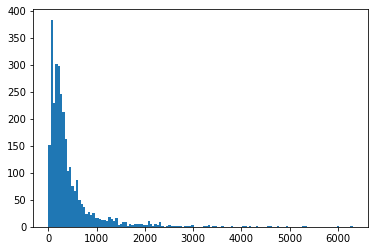

In [11]:
# histogram of lengths of training sequences
plt.hist(train_lengths, bins='auto')

In [12]:
min(train_lengths), max(train_lengths)

(4, 6308)

In [15]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

# Padding

In [16]:
from random import shuffle
from math import floor

# converting train to tensors
# train = [[torch.from_numpy(t[0].astype(int)).float(), torch.from_numpy(np.ndarray([int(t[1])]))] for t in train]
train_data = [[torch.from_numpy(t[0].astype(int)).float(), int(t[1])] for t in train]

dataset_length = len(train_data)
val_size = floor(dataset_length * VALIDATION_PERCENTAGE)
train_size = dataset_length - val_size

train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])

train_subset_data = [item[0] for item in train_subset]
train_subset_targets = [item[1] for item in train_subset]

val_subset_data = [item[0] for item in val_subset]
val_subset_targets = [item[1] for item in val_subset]

train_set = VariableLenDataset(train_subset_data, train_subset_targets)
val_set = VariableLenDataset(val_subset_data, val_subset_targets)

In [17]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)

    return xx_pad, yy

In [18]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [19]:
next(iter(train_loader))

(tensor([[132.,   8.,  12.,  ...,   0.,   0.,   0.],
         [ -1.,  48., 146.,  ...,   0.,   0.,   0.],
         [ -1.,  -1.,  -1.,  ...,   0.,   0.,   0.],
         ...,
         [ 80.,   2., 114.,  ...,   0.,   0.,   0.],
         [ -1.,  -1.,  -1.,  ...,   0.,   0.,  -1.],
         [  0.,  12.,  47.,  ...,   0.,   0.,   0.]]),
 (0, 1, 0, 3, 0, 4, 0, 0))

# Model

In [50]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc = nn.Linear(hidden_size, out_size)
        # self.fc = nn.Linear(hidden_size*90*self.bidirectional, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        # pass the input through the LSTM layer
        # print(x.shape)
        # print(hidden[0].size(0))
        out, _ = self.lstm(x, hidden)

        # print("OUT", out.shape)
        
        # get the last output of the LSTM layer
        out = out[-1, :, :]

        # print("OUT2", out.shape)
        
        # pass the last output through the fully-connected layer
        out = self.fc(out)

        # print("OUT3", out.shape)
        
        return out


In [51]:
    
model = LSTMRegressor(1,10,2,5).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 10, num_layers=2, dropout=0.4)
  (fc): Linear(in_features=10, out_features=5, bias=True)
)

# Training

In [53]:
%%time
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        targets = torch.from_numpy(np.asarray(targets))
        # print("SHAPE X", x.shape)
        # print("SHAPE TARGETS", targets.shape)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 

        # print(hidden.shape, state.shape)
        
        x = torch.transpose(x, 0, 1)
        # print("A")
        preds = model(x, (hidden, state))
        # print("B")
        # preds = torch.transpose(preds, 0, 1)
        # preds = preds.squeeze(2)
        # print("PREDS", preds.shape)
        # preds = preds[:,-1,:]
        
#         x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
#         preds_packed, _ = model(x_packed, (hidden, state))
#         preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        # preds = preds.squeeze(2)
        optimizer.zero_grad()
        # mask = targets != pad
        # loss = loss_fun(preds[mask], targets[mask])
        # print("PREDS", preds.shape)
        # print("TARGETS", targets.shape)

        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 1.57
Epoch: 1, loss: 1.8
Epoch: 2, loss: 1.15
Epoch: 3, loss: 0.723
Epoch: 4, loss: 1.15
Epoch: 5, loss: 1.49
Epoch: 6, loss: 1.61
Epoch: 7, loss: 1.3
Epoch: 8, loss: 1.3
Epoch: 9, loss: 1.49
Epoch: 10, loss: 1.12
Epoch: 11, loss: 0.969
Epoch: 12, loss: 0.775
Epoch: 13, loss: 1.49
Epoch: 14, loss: 0.711
Epoch: 15, loss: 1.03
Epoch: 16, loss: 1.42
Epoch: 17, loss: 0.873
Epoch: 18, loss: 1.01
Epoch: 19, loss: 1.08
Epoch: 20, loss: 1.37
Epoch: 21, loss: 0.825
Epoch: 22, loss: 1.33
Epoch: 23, loss: 1.02
Epoch: 24, loss: 1.08
Epoch: 25, loss: 1.57
Epoch: 26, loss: 1.18
Epoch: 27, loss: 0.855
Epoch: 28, loss: 1.93
Epoch: 29, loss: 0.839
Epoch: 30, loss: 0.991
Epoch: 31, loss: 0.683
Epoch: 32, loss: 1.13
Epoch: 33, loss: 1.48
Epoch: 34, loss: 1.26
Epoch: 35, loss: 1.16
Epoch: 36, loss: 0.413
Epoch: 37, loss: 0.835
Epoch: 38, loss: 0.972
Epoch: 39, loss: 1.79
Epoch: 40, loss: 1.17
Epoch: 41, loss: 1.73
Epoch: 42, loss: 1.24
Epoch: 43, loss: 0.858
Epoch: 44, loss: 0.954
Epoch: 4

In [48]:
def plot_results(epochs, losses):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

In [54]:
plot_results(epochs, losses)

NameError: ignored